In [142]:
import os
import datetime
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import glob
import scipy.io as sio

import netCDF4 as nc
from salishsea_tools import (viz_tools, tidetools, teos_tools)
from nowcast import (analyze, figures, research_ferries_test as rft)

%matplotlib inline

In [72]:
from importlib import reload

In [73]:
period = '1h'
grid = 'grid_T'
dmy = '14dec15'
date = datetime.datetime.strptime(dmy, "%d%b%y")
dayf = date - datetime.timedelta(days=1)
dmyf = dayf.strftime('%d%b%y').lower()
print(dmyf)

13dec15


Step 0: Load the datasets and files that are available in nowcast/make_plots. 
These will be used as inputs, not to be reloaded in the module

In [133]:
grid_T_hr = nc.Dataset(analyze.get_filenames(date, date, period, grid, '/results/SalishSea/nowcast/')[0])
coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_SS2_bathy_data()
grid_B.shape

AttributeError: NetCDF: Attribute not found

## A : Preparing ferry data
Step 1: Get ferry data

In [88]:
route_name='TWSB'
start_time = date.replace(hour=rft.route[route_name]['start']['hour'], minute=rft.route[route_name]['start']['minute'])
end_time = date.replace(hour=rft.route[route_name]['end']['hour'], minute=rft.route[route_name]['end']['minute'])
print(start_time, end_time)

2015-12-14 02:00:00 2015-12-14 04:00:00


In [89]:
obs = rft._get_sal_data(route_name, dmyf)

Step 2: Slicing ferry data

In [156]:
obs_sal = rft.ferry_salinity(route_name, dmy)

## B: Preparing model data

In [157]:
sal_a, sal_b = rft._get_nemo_salinity('TWDP', grid_T_hr)
print(sal_a[354:360,221:226], sal_b.shape)

[[  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          27.28442764  27.10847473]
 [  0.           0.           0.          28.13996696  27.96483231]
 [  0.           0.           0.          28.79513931  28.62794685]
 [  0.          27.15288734  27.29470634  28.24154472  28.51570511]
 [ 26.66689682  27.82665062  27.91036415  28.09919357  28.22037697]] (898, 398)


(48.75, 49)

/home/mdunn/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


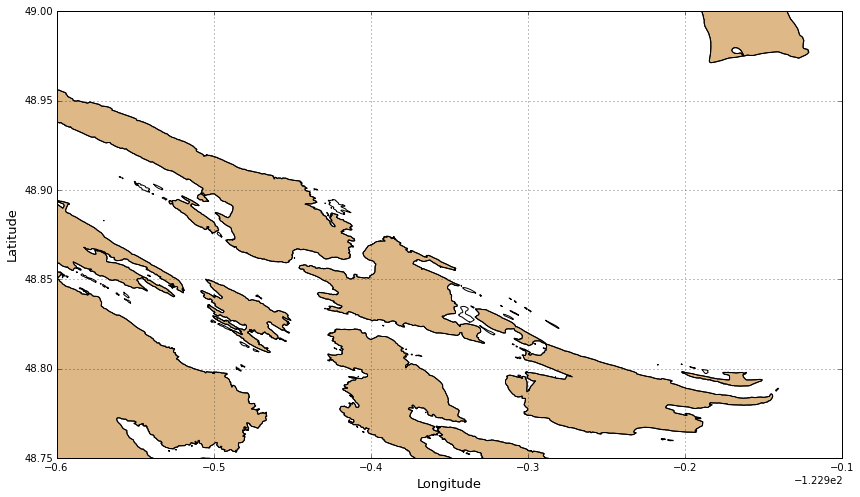

In [143]:
fig, ax = plt.subplots(figsize=(15, 8))
figures.plot_map(ax, grid_B, coastline)
viz_tools.set_aspect(ax)
ax.set_xlim(-123.5, -123)
ax.set_ylim(48.75, 49)
                

## C: Find corresponding model point to obs data
For each ferry route point we want to find the closest model point. From that model point we then find the 8 nearest points and compute and inverse distance interpolation.

In [108]:
rft._model_IDW(obs_sal[:,1], bathy, grid_T_hr, sal_a, sal_b)

(21.149457894404879, 18.297859974025723)

In [158]:
sal_val, sal_val_b = rft.nemo_sal_route(grid_T_hr, bathy, route_name, obs_sal)
print(sal_val_b)

[ 18.35971403  21.58885842  27.98111499  28.1082286   29.18613976
  29.53480654  29.56283044  29.62662262  29.67319034  29.68751179
  29.71045059  27.39134694  14.74215512  21.59388186  29.815768    28.5997901
  30.03304389  30.05834675  30.11095382  30.16161147  30.15652375
  30.14513827  27.89917296  28.19900894  24.33076791]


In [162]:
val_a_sum = 0
val_b_sum = 0
weight_sum = 0
for i in np.arange(obs_sal.shape[1]):
    [x1, y1] = tidetools.find_closest_model_point(obs[1,i],
                                                  obs[2,i],
                                                  X,
                                                  Y,
                                                  bathy,
                                                  lat_tol=0.00210,
                                                  allow_land=False)

    print(sal_b[x1, y1])
    for i in np.arange(x1 - 1, x1 + 2):
        for j in np.arange(y1 - 1, y1 + 2):
            dist = tidetools.haversine(
                obs[1,i], obs[2,i], X[i, j], Y[i, j])
            weight = 1.0 / dist
            weight_sum = weight_sum + weight
            if sal_a[i, j] == 0:
                val_a_sum = val_a_sum
                val_b_sum = val_b_sum
            else:
                val_a = sal_a[i, j] * weight
                val_b = sal_b[i, j] * weight
                val_a_sum = val_a_sum + val_a
                val_b_sum = val_b_sum + val_b

sal_a_idw = val_a_sum / weight_sum
sal_b_idw = val_b_sum / weight_sum
print(sal_a_idw)


27.1525
27.1525
27.1525
28.6382
28.6382
28.6382
28.6382
28.3409
28.3409
28.3409
29.3021
29.3021
29.3021
29.3021
29.3021
29.3021
29.3021
29.3021
27.2851
27.2851
27.2851
27.2851
27.2851
27.8573
27.8573
22.6170654129


In [165]:
reload(rft)

<module 'nowcast.research_ferries_test' from '/ocean/mdunn/MEOPAR/tools/SalishSeaNowcast/nowcast/research_ferries_test.py'>

/home/mdunn/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


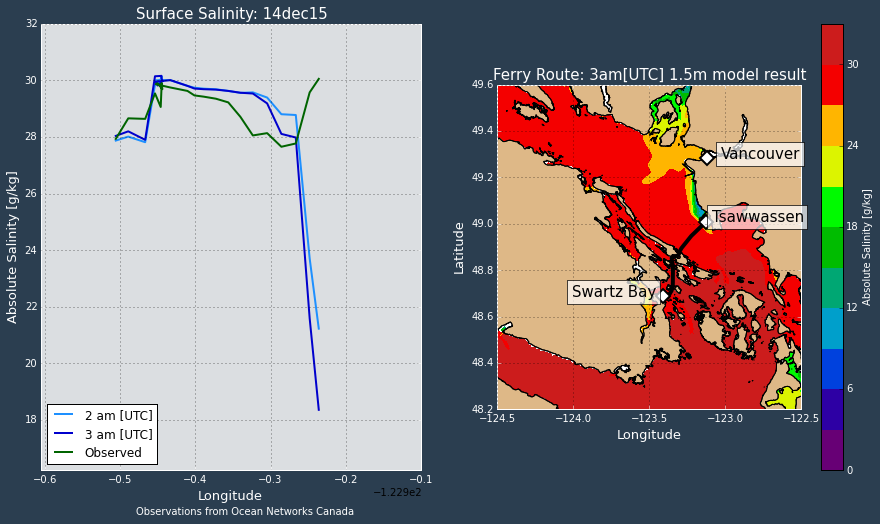

In [166]:
fig = rft.salinity_ferry_route(grid_T_hr, grid_B, bathy, coastline, 'TWSB', dmy)

/home/mdunn/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


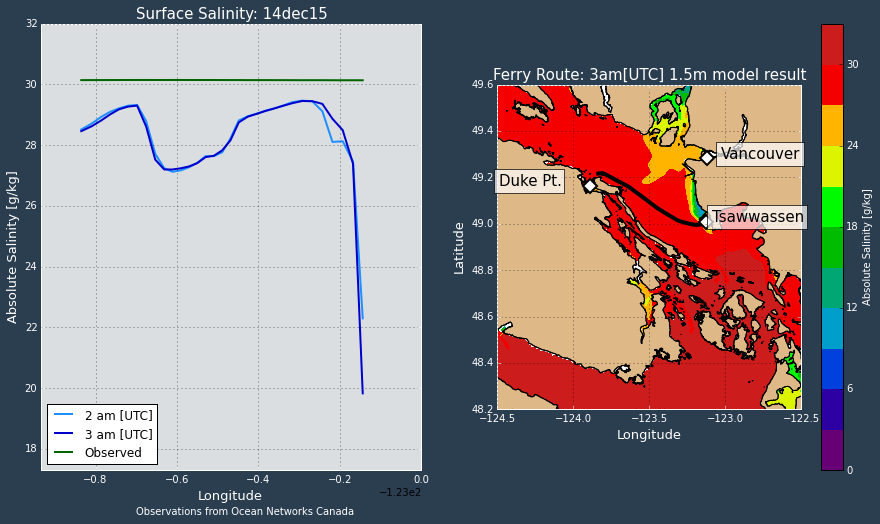

In [147]:
fig = rft.salinity_ferry_route(grid_T_hr, grid_B, bathy, coastline, 'TWDP', dmy)